In [9]:
%load_ext autoreload
%autoreload 2
sys.path.append("..")
from como.logistic_ser import fit_ser
from como.logistic_susie import *
from ser_tests import *
import matplotlib.pyplot as plt
from jax.experimental import sparse

from como.logistic_regression import LogisticSusie
from como.component_distributions import PointMassComponent, NormalComponent
from como.twococomo import TwoComponentCoMo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
n, p = 1000, 2000
data = sim_ser(n, p, -3, 4)
offset = np.zeros(n)
params, hypers = init_ser(data)

elbo monotone: False, with min change: -0.0004730224609375
credible set: [1547]
CPU times: user 3 s, sys: 88.8 ms, total: 3.09 s
Wall time: 3.27 s


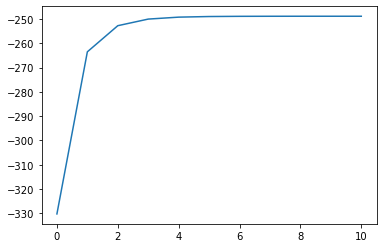

In [3]:
%%time
control = dict(
    update_b = True,
    update_xi = True,
    update_delta = True,
    update_hypers = True,
    track_elbo = True
)
params, hypers, elbo = fit_ser(data, control=control, niter=100, tol=1e-3)
params['mu'].block_until_ready()
plt.plot(elbo)

is_monotone = lambda x: np.alltrue((np.roll(x, -1) - x)[:-1] >=0)
min_delta = lambda x: np.min((np.roll(x, -1) - x)[:-1])

print(f'elbo monotone: {is_monotone(elbo)}, with min change: {min_delta(elbo)}')
print(f'credible set: {get_credible_set(params["alpha"])}')

In [4]:
%%time
n, p = 1000, 5000
L = 10
data = sim_susie(n, p, -4, np.array([2., 4., 6.]))

CPU times: user 139 ms, sys: 12.4 ms, total: 152 ms
Wall time: 154 ms


elbo monotone: True, with min change: 0.00627899169921875


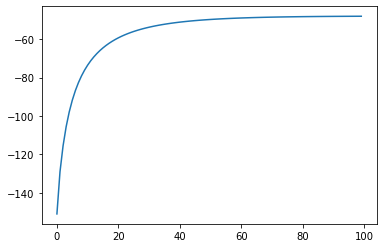

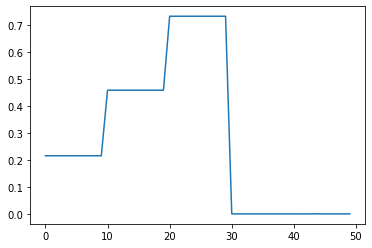

In [5]:
params, hypers, elbo, diff, iter = fit_susie(data, L, 100)
elbo.block_until_ready()
print(f'elbo monotone: {is_monotone(elbo)}, with min change: {min_delta(elbo)}')

plt.plot(elbo); plt.show()
cs = {f'L{k+1}': get_credible_set(params['alpha'][k]) for k in range(L)}
plt.close()

b = Eb_susie(params)
plt.plot(b[:50])

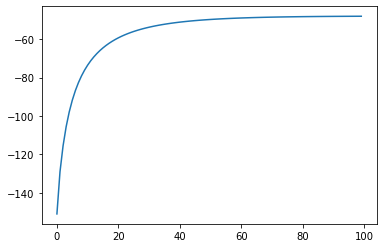

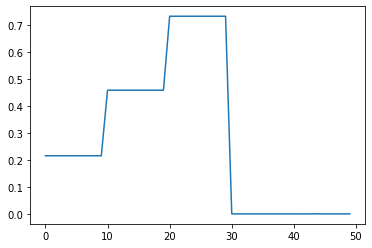

In [10]:
binfit = LogisticSusie(data, L=10)

elbo = []
for i in range(100):
    binfit.update()
    elbo.append(binfit.evidence())

plt.plot(elbo); plt.show()
cs = {f'L{k+1}': get_credible_set(binfit.params['alpha'][k]) for k in range(L)}
plt.close()

b = Eb_susie(binfit.params)
plt.plot(b[:50])

In [11]:
from como.component_distributions import PointMassComponent, NormalComponent

f0 = PointMassComponent(5)
f1 = NormalComponent(5, 1.)

print(f0.convolved_logpdf(np.linspace(0, 10, 20), np.ones(20)))
print(f1.convolved_logpdf(np.linspace(0, 10, 20), np.ones(20)))

[-13.418939  -10.925864   -8.709797   -6.7707386  -5.1086893  -3.7236476
  -2.6156142  -1.7845895  -1.2305727  -0.9535645  -0.9535645  -1.2305727
  -1.7845898  -2.6156147  -3.7236476  -5.1086893  -6.77074    -8.709798
 -10.925864  -13.418939 ]
[-7.5155125 -6.2689753 -5.1609416 -4.1914124 -3.3603878 -2.6678667
 -2.11385   -1.6983376 -1.4213293 -1.2828251 -1.2828251 -1.4213293
 -1.6983378 -2.11385   -2.6678667 -3.3603878 -4.191413  -5.160942
 -6.2689753 -7.5155125]


In [12]:
from como.logistic_regression import LogisticSusie

n, p = 1000, 5000
L = 4
data = sim_susie(n, p, -4, np.array([2., 4., 6.]))
data.keys()

dict_keys(['y', 'p', 'X', 'Z', 'params'])

In [13]:
%%time
logistic_susie = LogisticSusie(data)
elbo_susie(
    logistic_susie.data,
    logistic_susie.params,
    logistic_susie.hypers
)
for i in range(100):
    logistic_susie.update()
    elbo_susie(logistic_susie.data, logistic_susie.params, logistic_susie.hypers)

logistic_susie.report_credible_sets()

CPU times: user 5.84 s, sys: 562 ms, total: 6.4 s
Wall time: 5.71 s


{'L1': DeviceArray([20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32),
 'L2': DeviceArray([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32),
 'L3': DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 'L4': DeviceArray([3972,  971,  495, ..., 1960, 3650, 2661], dtype=int32),
 'L5': DeviceArray([3972,  971,  495, ..., 1960, 3650, 2661], dtype=int32),
 'L6': DeviceArray([3972,  971,  495, ..., 1960, 3650, 2661], dtype=int32),
 'L7': DeviceArray([3972,  971,  495, ..., 1960, 3650, 2661], dtype=int32),
 'L8': DeviceArray([3972,  971,  495, ..., 1960, 3650, 2661], dtype=int32),
 'L9': DeviceArray([3972,  971,  495, ..., 1960, 3650, 2661], dtype=int32),
 'L10': DeviceArray([3972,  971,  495, ..., 1960, 3650, 2661], dtype=int32)}

In [14]:
def sim_sumstat_susie(n, p, b0, b, scale=1):
    #mix = np.exp(-np.abs(np.arange(p) - np.arange(p)[:, None]) / 3)
    #X = np.random.binomial(1, 0.2, size=n*p).reshape(n, -1) @ mix
    X = np.random.normal(size=n*p).reshape(n, -1) #@ mix
    X[:, :9] = X[:, 9][:, None]
    X[:, 10:19] = X[:, 19][:, None]
    X[:, 20:29] = X[:, 29][:, None]
    
    logits = b0 + X[:, [9, 19, 29]] @ b
    p = jnp.clip(sigmoid(b0 + X[:, [9, 19, 29]] @ b), 1e-8, 1-1e-8)
    # p = jnp.clip(sigmoid(logits), 1e-8, 1-1e-8)

    y = np.random.binomial(1, p)
    se = np.random.uniform(1, 5, size=n)
    beta = y * np.random.normal(size=n) * scale
    beta_hat = beta + np.random.normal(size=n)* se

    data = {
        'beta_hat': beta_hat,
        'beta': beta,
        'se': se,
        'y': y,
        'p' : p,
        'logits': logits,
        'X': X,
        'Z': np.ones((n, 1)),
        'params': dict(b0=b0, b=b)
    }
    return data

Below we simulate from the covariate moderated two component model.

(array([  4.,   4.,  59., 146., 852., 767., 123.,  33.,   8.,   4.]),
 array([-34.782378  , -27.7909075 , -20.79943701, -13.80796652,
         -6.81649603,   0.17497446,   7.16644495,  14.15791544,
         21.14938593,  28.14085642,  35.13232691]),
 <BarContainer object of 10 artists>)

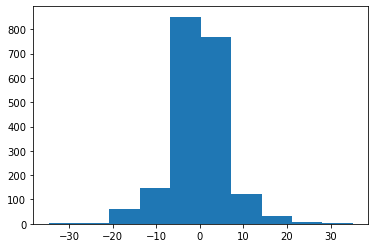

In [69]:
from como.component_distributions import PointMassComponent, NormalComponent
from como.logistic_regression import LogisticSusie
from como.twococomo import TwoComponentCoMo

n = 2000
p = 100
sim = sim_sumstat_susie(n, p, -4, np.array([2., 4., 6.]), scale=10)
data = dict(
    beta=sim['beta_hat'], se=sim['se']
)
data_logreg = dict(
    # y=np.random.uniform(size=n), X=sim['X'], Z=sim['Z']
    y=sim['y'], X=sim['X'], Z=sim['Z']
)

plt.hist(data['beta'])

In [77]:
def binarize_sim(sim, z_thresh):
    y = (np.abs(sim['beta_hat'] / sim['se']) > z_thresh).astype(float)
    return y

def cs_plot(fit):
    for l in range(fit.L):
        alpha = fit.params['alpha'][l]
        cs = get_credible_set(alpha)
        plt.scatter(cs, alpha[cs])

def fit_and_plot(fit, niter=100):
    elbos = [fit.elbo()]
    diff = lambda x: x[-1].get('total_elbo') - x[-2].get('total_elbo')

    for i in range(niter):
        fit.update_responsibilities()
        elbos.append(fit.elbo())

        fit.logreg.update()
        elbos.append(fit.elbo())

        fit.f0.update()
        fit.f1.update()

    import pandas as pd
    elbo_df = pd.DataFrame(elbos)
    print(is_monotone(elbo_df.total_elbo))

    fig, ax = plt.subplots(1, 3)
    ax[0].plot(elbo_df.total_elbo)

    binfit = fit.logreg
    plt.sca(ax[1])
    cs_plot(binfit)
    ax[2].scatter(binfit.predict(), sim['logits'])
    plt.show()

    # fig, ax = plt.subplots(2, 2)
    # ax[0, 0].plot(elbo_df.data_loglik)
    # ax[0, 1].plot(elbo_df.assignment_entropy)
    # ax[1, 0].plot(elbo_df.logistic_elbo)
    # ax[1, 1].plot(elbo_df.total_elbo)
    # plt.show(); plt.close()

    # binfit = fit.logreg
    # b = Eb_susie(binfit.params)
    # plt.plot(b[:50]); plt.show(); plt.close()
    # plt.scatter(binfit.predict(), sim['logits'])


def fit_and_plot_logstic(sim, thresh):
    data_logreg = dict(
        y=binarize_sim(sim, thresh), X=sim['X'], Z=sim['Z']
    )
    binfit = LogisticSusie(data_logreg, L=10)
    elbo = []
    for i in range(100):
        binfit.update()
        elbo.append(binfit.evidence())

    fig, ax = plt.subplots(1, 3)
    ax[0].plot(elbo)

    plt.sca(ax[1])
    cs_plot(binfit)
    ax[2].scatter(binfit.predict(), sim['logits'])
    plt.show()

When we fit the logistic model with the true binary status of each observation, we do great! The problem is we don't usually get to observe this.

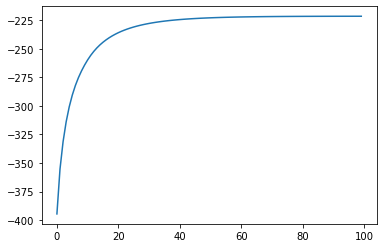

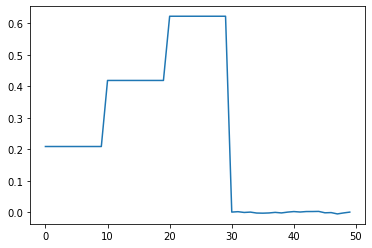

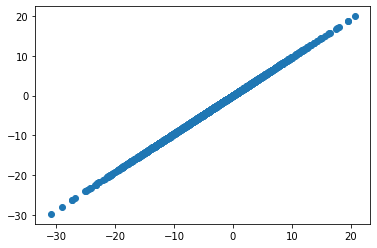

In [73]:
data_logreg = dict(
    y=sim['y'], X=sim['X'], Z=sim['Z']
)
binfit = LogisticSusie(data_logreg, L=10)

elbo = []
for i in range(100):
    binfit.update()
    elbo.append(binfit.evidence())

plt.plot(elbo); plt.show()
cs = {f'L{k+1}': get_credible_set(binfit.params['alpha'][k]) for k in range(L)}
plt.close()

b = Eb_susie(binfit.params)
plt.plot(b[:50]); plt.show(); plt.close()

plt.scatter(binfit.predict(), sim['logits'])

True


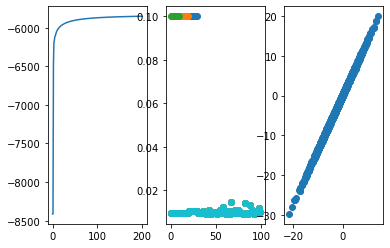

In [74]:
# initialize
# notice that we don't get to see the true component each obervation belongs
# but we are giving the model the correct component distributions

data_logreg = dict(
    y=np.random.uniform(sim['y'].size), X=sim['X'], Z=sim['Z']
)

f0 = PointMassComponent(0.0)
f1 = NormalComponent(0, 10.0)
logreg = LogisticSusie(data_logreg, L=10)
fit = TwoComponentCoMo(data, f0, f1, logreg)
fit_and_plot(fit)


Given the correct component distribution we are able to do a great job actually. However, this is a very easy problem... we can make it harder by making it harder to distinguish betwee null/non-null cases.

False


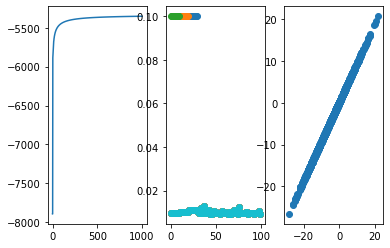

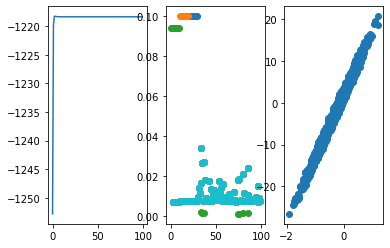

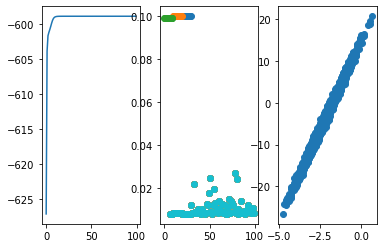

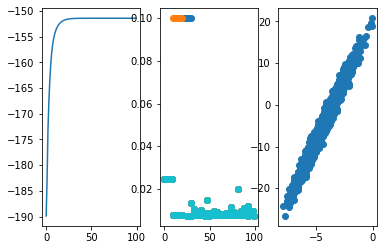

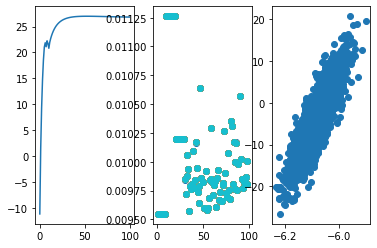

In [83]:
n = 2000
p = 100
scale = 5.
sim = sim_sumstat_susie(n, p, -4, np.array([2., 4., 6.]), scale=scale)
data = dict(
    beta=sim['beta_hat'], se=sim['se']
)
data_logreg = dict(
    # y=np.random.uniform(size=n), X=sim['X'], Z=sim['Z']
    y=sim['y'], X=sim['X'], Z=sim['Z']
)

data_logreg = dict(
    y=np.random.uniform(sim['y'].size), X=sim['X'], Z=sim['Z']
)

f0 = PointMassComponent(0.0)
f1 = NormalComponent(0, scale)
logreg = LogisticSusie(data_logreg, L=10)
fit = TwoComponentCoMo(data, f0, f1, logreg)
fit_and_plot(fit, niter=500)
fit_and_plot_logstic(sim, 1)
fit_and_plot_logstic(sim, 2)
fit_and_plot_logstic(sim, 4)
fit_and_plot_logstic(sim, 8)

So when it is noisier it is harder to detect (we miss on of the 3 signals). A key question is if we can do better here vs thresholding.

Given the correct componeng distribution, we are able to recover all three signals. In comparison, only the z-score threshold of 2 was able to recover the three signals.

Strikingly, our predictions on the log-odds scale are much better, suggesting that the summary stat model can better recover enrichment effects.

I wonder if there is a way to derive an optimal threshold for recover (given the true component distribution).

On that note, this is not quite a fair assessment yet. We gave the summary stat model the true component distribtions. We ought to be able to learn these....